Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка и подготовка данных

In [ ]:
import os
import time
import zipfile
from pathlib import Path

import gdown  # Подключим функцию gdown
# Отрисовка графиков
import matplotlib.pyplot as plt
import numpy as np
# Работа с таблицами
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Основные слои
from tensorflow.keras.layers import (Dense,
                                     Dropout, Embedding, Flatten, Input,
                                     SpatialDropout1D)
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer


Функция для скачивания и распаковки архива с датасетом.

Аргументы:
- url: ссылка для скачивания архива
- output_dir: путь для сохранения распакованных данных

Действия:
1. Создает директорию для данных, если она не существует
2. Скачивает архив по указанной ссылке
3. Распаковывает архив в указанную директорию
4. Удаляет скачанный архив после распаковки

In [5]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')
    
    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)
    
    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

Загрузка и распаковка архива с данными.
Используется функция download_and_extract с указанием URL архива и целевой директории.

In [6]:
# Загрузка и распаковка архива
download_and_extract('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', '20writers')

Скачивание архива...


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip
To: c:\Users\HAIER\Desktop\Задания\Основы нейронных сетей\Занятие 4\nn_lab_4\ДЗ\20writers\dataset.zip
100%|██████████| 28.5M/28.5M [00:06<00:00, 4.44MB/s]


Распаковка архива...
Датасет готов к использованию


Чтение текстовых файлов из директории и подготовка данных:
1. Создается объект Path для работы с директорией
2. Для каждого файла в директории:
   - Имя файла добавляется в список class_names (названия классов)
   - Содержимое файла читается, удаляются переносы строк и добавляется в список text

In [11]:
path = Path("20writers")
text = []
class_names = []
for f in path.iterdir():
    class_names.append(f.name)
    text.append(f.read_text().replace("\n", " "))

Вычисление длины каждого текста и определение индексов для разделения на обучающую и тестовую выборки.
Обучающая выборка будет содержать 80% текста, тестовая - 20%.

In [12]:
text_lens = [len(t) for t in text]
split_indices = [int(lenth * 0.8) for lenth in text_lens]

Вывод длин текстов для проверки балансировки данных.

In [13]:
print(text_lens)

[2152214, 2523380, 2255254, 1965119, 1992830, 2952792, 6611627, 3408339, 2328900, 3104712, 5178950, 1980206, 969109, 3357061, 2399413, 2001064, 3386268, 1972541, 3089426, 2579246]


Разделение текстов на обучающую и тестовую выборки согласно вычисленным индексам.
Для каждого текста:
- Первые 80% символов идут в train_text
- Остальные 20% символов идут в test_text

In [14]:
train_text = []
test_text = []
for i, t in enumerate(text):
    train_text.append(t[:split_indices[i]])
    test_text.append(t[split_indices[i]:])

Визуализация балансировки данных:
- Строится столбчатая диаграмма, показывающая количество символов в обучающей и тестовой выборках для каждого класса
- Обучающая выборка отображается первым набором столбцов
- Тестовая выборка отображается поверх обучающей

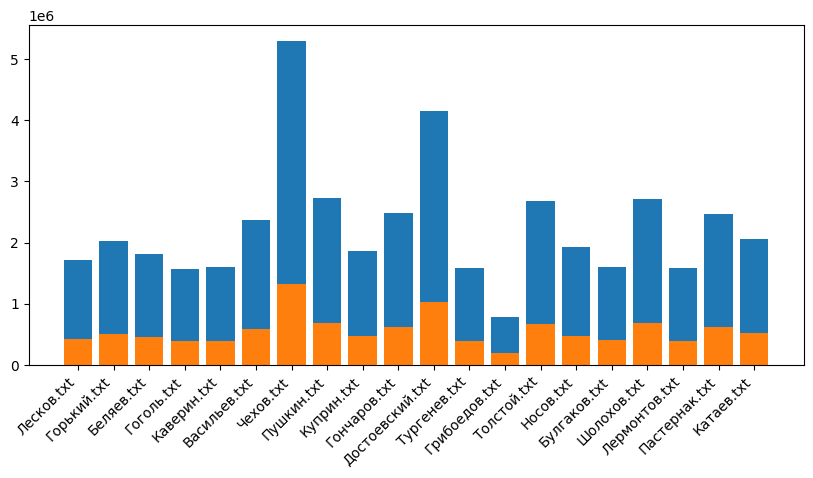

In [15]:
# Проверка сбалансированности выборок по классам
fig = plt.figure(figsize=(10, 5))
c_train = split_indices
c_test = [i-j for i, j in zip(text_lens, split_indices)]
plt.bar(class_names, c_train)
plt.bar(class_names, c_test)
fig.autofmt_xdate(rotation=45)
plt.show()

Определение параметров для обработки текста:
- VOCAB_SIZE: максимальное количество слов в словаре
- WIN_SIZE: размер окна для разбиения текста
- WIN_HOPE: шаг окна для разбиения текста

Функции для обработки последовательностей:
1. split_sequence - разбивает последовательность на отрезки скользящим окном
2. vectorize_sequence - формирует выборку отрезков и соответствующих меток классов в one-hot encoding

In [16]:
VOCAB_SIZE = 25000
WIN_SIZE = 4000
WIN_HOPE = 500


# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]
# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

Класс-таймер для измерения времени выполнения операций.
Используется как контекстный менеджер с помощью with.

In [17]:
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))

Токенизация текста и подготовка данных для обучения:
1. Создается токенизатор с указанными параметрами
2. Токенизатор обучается на всех текстах
3. Тексты преобразуются в последовательности чисел
4. Формируются обучающая и тестовая выборки
5. Создаются матрицы Bag-of-Words для обучающей и тестовой выборок

In [18]:
with timex():
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE,
        filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
        lower=True,
        split=" ",
        oov_token="неизвестное_слово",
        char_level=False,
    )
    tokenizer.fit_on_texts(text)
    seq_train = tokenizer.texts_to_sequences(train_text)
    seq_test = tokenizer.texts_to_sequences(test_text)
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOPE)
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOPE)

    x_train_bow = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")
    x_test_bow = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")

Время обработки: 49.79 с


Анализ балансировки классов в выборках:
1. Преобразование one-hot меток обратно в числовые
2. Подсчет количества примеров каждого класса с помощью np.bincount
3. Вывод статистики по количеству окон для каждого класса

In [19]:
# Преобразуем one-hot обратно в метки классов
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Подсчёт с помощью bincount
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Вывод результатов
print("Обучающая выборка:")
for cls, count in enumerate(train_counts):
    print(f"Класс {cls}: {count} окон")

print("\nТестовая выборка:")
for cls, count in enumerate(test_counts):
    print(f"Класс {cls}: {count} окон")

Обучающая выборка:
Класс 0: 537 окон
Класс 1: 647 окон
Класс 2: 532 окон
Класс 3: 479 окон
Класс 4: 479 окон
Класс 5: 706 окон
Класс 6: 1656 окон
Класс 7: 823 окон
Класс 8: 558 окон
Класс 9: 780 окон
Класс 10: 1294 окон
Класс 11: 484 окон
Класс 12: 239 окон
Класс 13: 829 окон
Класс 14: 586 окон
Класс 15: 470 окон
Класс 16: 791 окон
Класс 17: 488 окон
Класс 18: 726 окон
Класс 19: 602 окон

Тестовая выборка:
Класс 0: 121 окон
Класс 1: 153 окон
Класс 2: 127 окон
Класс 3: 115 окон
Класс 4: 115 окон
Класс 5: 169 окон
Класс 6: 422 окон
Класс 7: 194 окон
Класс 8: 134 окон
Класс 9: 188 окон
Класс 10: 327 окон
Класс 11: 116 окон
Класс 12: 52 окон
Класс 13: 206 окон
Класс 14: 150 окон
Класс 15: 111 окон
Класс 16: 201 окон
Класс 17: 117 окон
Класс 18: 171 окон
Класс 19: 143 окон


Вычисление весов классов для балансировки обучения.
Веса вычисляются обратно пропорционально частоте классов в обучающей выборке.

In [20]:
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1),
)
class_weight_dict = dict(enumerate(class_weights))

Функция для оценки модели:
1. Строит и отображает нормализованную матрицу ошибок
2. Выводит статистику по каждому классу
3. Вычисляет среднюю точность распознавания

Аргументы:
- model: обученная модель
- x: входные данные
- y_true: истинные метки
- class_labels: названия классов
- cm_round: округление значений матрицы ошибок
- title: заголовок для вывода
- figsize: размер графика

In [ ]:
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )

##Bag of words

Создание модели Bag of Words:
1. Входной слой размером VOCAB_SIZE
2. Dropout для регуляризации
3. Два скрытых полносвязных слоя с ReLU активацией
4. Выходной слой с softmax активацией для классификации
5. Компиляция модели с оптимизатором Adam и категориальной кросс-энтропией

In [34]:
model = Sequential(
    [
        Input((VOCAB_SIZE,)),
        Dropout(0.6),
        Dense(120, activation="relu"),
        Dropout(0.6),
        Dense(120, activation="relu"),
        Dropout(0.3),
        Dense(20, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │     3,000,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         2,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,017,060 (11.51 MB)

 Trainable params: 3,017,060 (11.51 MB)

 Non-trainable params: 0 (0.00 B)

Обучение модели Bag of Words:
- 30 эпох
- Размер батча 256
- Используются вычисленные веса классов для балансировки
- Валидация на тестовой выборке

In [37]:
history = model.fit(
    x_train_bow,
    y_train,
    epochs=30,
    batch_size=256,
    validation_data=(x_test_bow, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9865 - loss: 0.0358 - val_accuracy: 0.9742 - val_loss: 0.1302
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9863 - loss: 0.0369 - val_accuracy: 0.9754 - val_loss: 0.1410
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9852 - loss: 0.0380 - val_accuracy: 0.9742 - val_loss: 0.1284
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9855 - loss: 0.0333 - val_accuracy: 0.9754 - val_loss: 0.1428
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9880 - loss: 0.0300 - val_accuracy: 0.9742 - val_loss: 0.1445
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9869 - loss: 0.0340 - val_accuracy: 0.9733 - val_loss: 0.1539
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9876 - loss: 0.0322 - val_accuracy: 0.9757 - val_loss: 0.1197
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9875 - loss: 0.0282 - val_accuracy: 0.9760 - v

Визуализация процесса обучения:
1. График точности на обучающей и валидационной выборках
2. График потерь на обучающей и валидационной выборках
3. Оценка модели на тестовой выборке с помощью функции eval_model

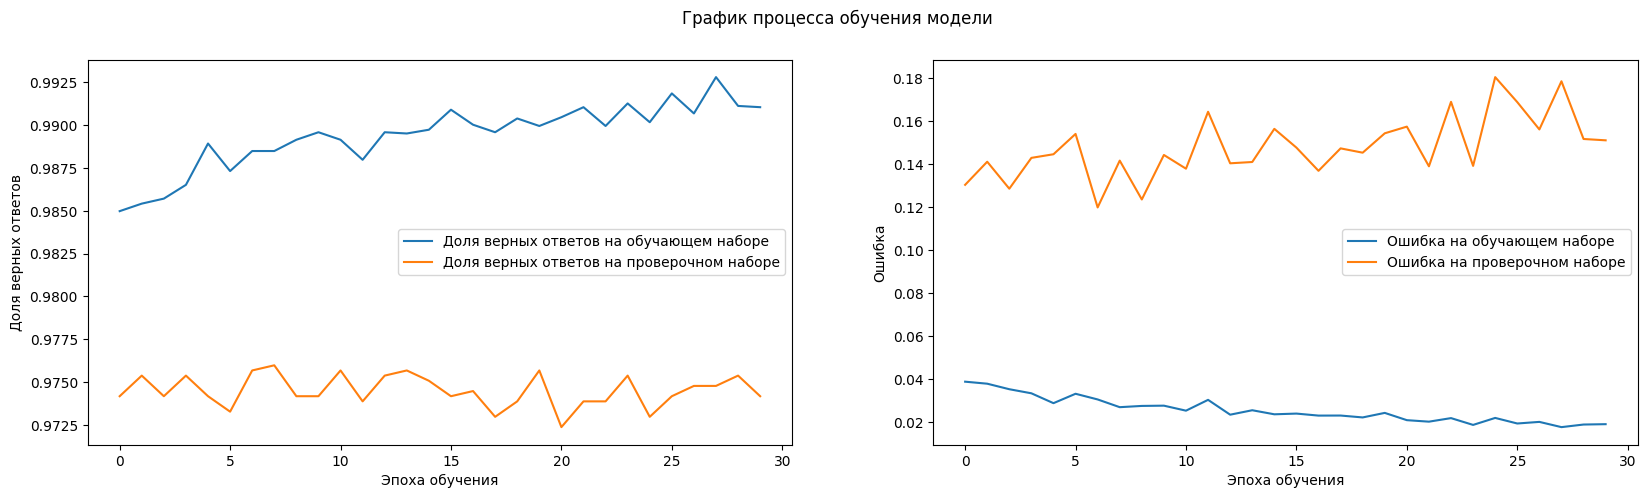

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(history.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()
eval_model(model, x_test_bow, y_test, class_names)

##Embedding

Создание модели с Embedding слоем:
1. Embedding слой для преобразования индексов слов в плотные векторы
2. SpatialDropout1D для регуляризации
3. Выравнивание данных с помощью Flatten
4. Два скрытых полносвязных слоя с ReLU активацией
5. Выходной слой с softmax активацией
6. Компиляция модели с оптимизатором Adam и категориальной кросс-энтропией

In [33]:
model_emb = Sequential(
    [
        Embedding(VOCAB_SIZE, 400, input_length=WIN_SIZE),
        SpatialDropout1D(0.4),
        Flatten(),
        Dense(120, activation="relu"),
        Dropout(0.4),
        Dense(120, activation="relu"),
        Dropout(0.4),
        Dense(20, activation="softmax"),
    ]
)
model_emb.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_emb.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Обучение модели с Embedding:
- 30 эпох
- Размер батча 256
- Используются вычисленные веса классов для балансировки
- Валидация на тестовой выборке

In [32]:
history_emb = model_emb.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=256,
    validation_data=(x_test, y_test),
    class_weight=class_weight_dict,
    verbose=1,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9997 - loss: 0.0036 - val_accuracy: 0.8286 - val_loss: 0.6190
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9990 - loss: 0.0044 - val_accuracy: 0.7893 - val_loss: 0.7125
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.8049 - val_loss: 0.7250
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9994 - loss: 0.0049 - val_accuracy: 0.8295 - val_loss: 0.6267
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.8283 - val_loss: 0.6126
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.8448 - val_loss: 0.5857
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9999 - loss: 0.0028 - val_accuracy: 0.8073 - val_loss: 0.6567
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy

Визуализация процесса обучения модели с Embedding:
1. График точности на обучающей и валидационной выборках
2. График потерь на обучающей и валидационной выборках
3. Оценка модели на тестовой выборке с помощью функции eval_model

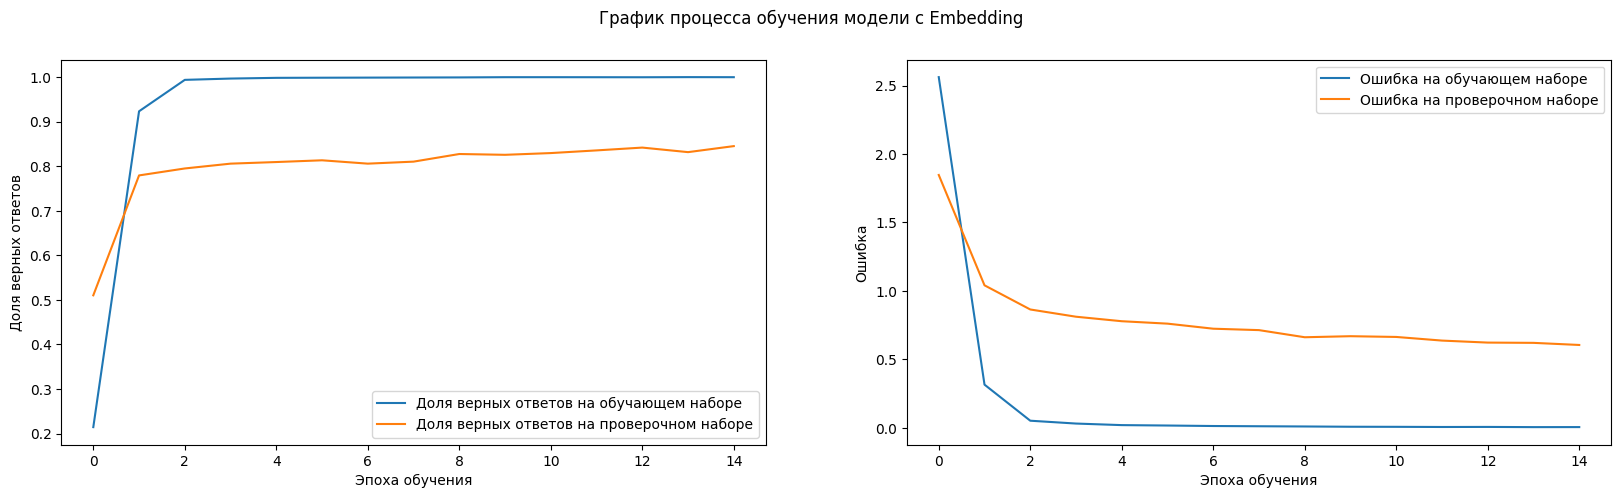

105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


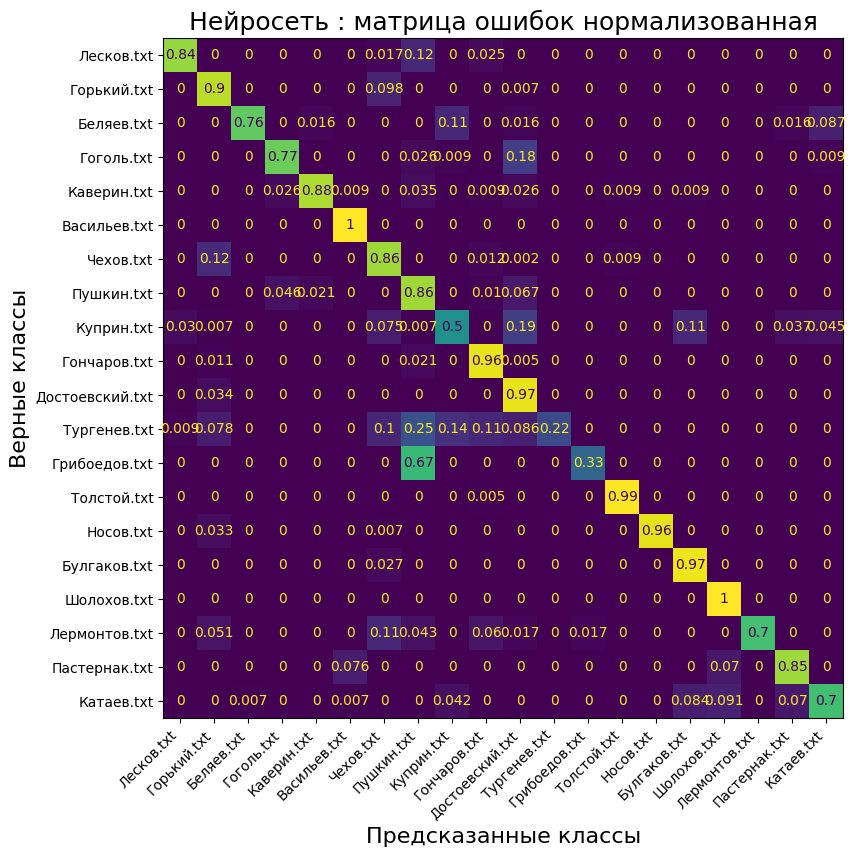

----------------------------------------------------------------------------------------------------
Нейросеть: 
Класс: Лесков.txt            84% сеть отнесла к классу Лесков.txt           - ВЕРНО :-)
Класс: Горький.txt           90% сеть отнесла к классу Горький.txt          - ВЕРНО :-)
Класс: Беляев.txt            76% сеть отнесла к классу Беляев.txt           - ВЕРНО :-)
Класс: Гоголь.txt            77% сеть отнесла к классу Гоголь.txt           - ВЕРНО :-)
Класс: Каверин.txt           88% сеть отнесла к классу Каверин.txt          - ВЕРНО :-)
Класс: Васильев.txt         100% сеть отнесла к классу Васильев.txt         - ВЕРНО :-)
Класс: Чехов.txt             86% сеть отнесла к классу Чехов.txt            - ВЕРНО :-)
Класс: Пушкин.txt            86% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Куприн.txt            50% сеть отнесла к классу Куприн.txt           - ВЕРНО :-)
Класс: Гончаров.txt          96% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: 

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели с Embedding")
ax1.plot(history_emb.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history_emb.history["val_accuracy"],
    label="Доля верных ответов на проверочном наборе",
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history_emb.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history_emb.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()
eval_model(model_emb, x_test, y_test, class_names)